In [1]:
import sacc
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pylab as plt 
import numpy as np
import pyccl as ccl
import classy

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
ZMAX = 2.0
ELLMIN = 2
NELL = 30
ELLMAX_GC = 300
ELLMAX_WL = 3000
KMIN = 1E-4
KMAX = 50 
ZMIN = 0.0 

jc.power.USE_EMU = False

In [3]:
def get_nz(sfile, tracertype="wl"):
    tracers_names = list(sfile.tracers.keys())

    if tracertype == "wl":
        tname = "DESwl__"
    else:
        tname = "DESgc__"
    nbin = sum([tname in tracers_names[i] for i in range(len(tracers_names))])

    nz_distributions = list()
    for i in range(nbin):
        name = tname + str(i)
        distribution = sfile.tracers[name]
        jaxred = jc.redshift.custom_nz(
            distribution.z.astype("float64"),
            distribution.nz.astype("float64"),
            zmax=ZMAX,
        )
        nz_distributions.append(jaxred)

    return nz_distributions

In [44]:
def unpack_params_vec(params):
    cosmo = jc.Cosmology(
        sigma8=params[0],
        Omega_c=params[1],
        Omega_b=params[2],
        h=params[3],
        n_s=params[4],
        w0=-1.0,
        Omega_k=0.0,
        wa=0.0,
    )
    mparam_1, mparam_2, mparam_3, mparam_4 = params[5:9]
    dz1, dz2, dz3, dz4 = params[9:13]
    a_ia_param, eta_param = params[13], params[14]
    b1, b2, b3, b4, b5 = params[15], params[16], params[17], params[18], params[19]
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = (
        params[20],
        params[21],
        params[22],
        params[23],
        params[24],
    )
    return (
        cosmo,
        [mparam_1, mparam_2, mparam_3, mparam_4],
        [dz1, dz2, dz3, dz4],
        [a_ia_param, eta_param],
        [b1, b2, b3, b4, b5],
        [dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5],
    )

def get_params_vec(cosmo, multiplicative, deltaz, ia_params, bias, deltaz_gc):
    mparam_1, mparam_2, mparam_3, mparam_4 = multiplicative
    dz1, dz2, dz3, dz4 = deltaz
    a_ia_param, eta_param = ia_params
    b1, b2, b3, b4, b5 = bias
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = deltaz_gc
    return jnp.array(
        [
            cosmo.sigma8,
            cosmo.Omega_c,
            cosmo.Omega_b,
            cosmo.h,
            cosmo.n_s,
            mparam_1,
            mparam_2,
            mparam_3,
            mparam_4,
            dz1,
            dz2,
            dz3,
            dz4,
            a_ia_param,
            eta_param,
            b1,
            b2,
            b3,
            b4,
            b5,
            dz_gc_1,
            dz_gc_2,
            dz_gc_3,
            dz_gc_4,
            dz_gc_5,
        ]
    )


def get_test_param():
    cosmo = jc.Cosmology(
        sigma8=0.852,
        Omega_c=0.239,
        Omega_b=0.054,
        h=0.653,
        n_s=0.933,
        w0=-1.0,
        Omega_k=0.0,
        wa=0.0,
    )

    parameter = get_params_vec(
        cosmo,
        [0.074, 0.186, -0.075, -0.108], # [0.0, 0.0, 0.0, 0.0], #  # multiplicative
        [0.0, 0.0, 0.0, 0.0], # [-0.008, -0.100, -0.0018, -0.0097], # shifts wl 
        [0.0, -0.011], # [0.359, -0.011], # a_ia, eta
        [1.34, 1.58, 1.60, 1.90, 1.94], # [1.0, 1.0, 1.0, 1.0, 1.0], # , # biases 
        [0.0, 0.0, 0.0, 0.0, 0.0] #[0.022, -0.0015, 0.02, 0.0097, -0.012], # shifts gc
    )
    return parameter

def get_index_pairs(nbin1, nbin2=None, auto=False):
    cl_index = list()
    if nbin2 is not None:
        for i in range(nbin1):
            for j in range(nbin2):
                cl_index.append([i, j + nbin1])
    elif auto:
        for i in range(nbin1):
            cl_index.append([i, i])
    else:
        for i in range(nbin1):
            for j in range(i, nbin1):
                cl_index.append([i, j])
    return cl_index

In [45]:
saccfile = sacc.Sacc.load_fits("data/cls_DESY1.fits")
jax_nz_wl = get_nz(saccfile, tracertype="wl")
jax_nz_gc = get_nz(saccfile, tracertype="gc")
parameters = get_test_param()

In [46]:
# plt.figure(figsize = (12, 4))
# plt.subplot(121)
# plt.title('Weak Lensing')
# for i in range(4):
#     plt.plot(jax_nz_wl[i].params[0], jax_nz_wl[i].params[1])
# plt.ylim(0.0, 4.0)
# plt.xlim(0.0, 2.5)

# plt.subplot(122)
# plt.title('Galaxy Clustering')
# for i in range(5):
#     plt.plot(jax_nz_gc[i].params[0], jax_nz_gc[i].params[1])
# plt.ylim(0.0, 9.0)
# plt.xlim(0.0, 1.5)
# plt.show()

In [47]:
def get_gc_powerspectra(parameters, jax_nz_gc):
    (
        cosmo,
        multiplicative,
        deltaz_wl,
        (a_ia_param, eta_param),
        bias,
        deltaz_gc,
    ) = unpack_params_vec(parameters)
    nbin_gc = len(deltaz_gc)
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias]
    nz_gc_sys = [
        jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX)
        for nzi, dzi in zip(jax_nz_gc, deltaz_gc)
    ]
    probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]
    ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=jnp.float32)
    idx_pairs_gc = get_index_pairs(nbin_gc, auto=True)
    ps_gc = jc.angular_cl.angular_cl(
        cosmo, ells_coarse, probes_gc, index_pairs=idx_pairs_gc
    )
    return ps_gc, ells_coarse, nbin_gc


def get_gc_wl_powerspectra(parameters, jax_nz_gc, jax_nz_wl):
    (
        cosmo,
        multiplicative,
        deltaz_wl,
        (a_ia_param, eta_param),
        bias,
        deltaz_gc,
    ) = unpack_params_vec(parameters)
    nbin_gc = len(deltaz_gc)
    nbin_wl = len(deltaz_wl)

    # apply all the systematics here (shifts, multiplicative bias, intrinsic alignment)
    nz_wl_sys = [
        jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)
    ]
    nz_gc_sys = [
        jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_gc, deltaz_gc)
    ]
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias]
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)

    probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]
    probes_wl = [
        jc.probes.WeakLensing(
            nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative
        )
    ]
    probes_gc_wl = probes_gc + probes_wl

    ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=jnp.float32)
    idx_pairs_gc_wl = get_index_pairs(nbin_gc, nbin_wl, auto=False)
    ps_gc_wl = jc.angular_cl.angular_cl(
        cosmo, ells_coarse, probes_gc_wl, index_pairs=idx_pairs_gc_wl
    )
    return ps_gc_wl, ells_coarse, nbin_gc, nbin_wl


def get_wl_powerspectra(parameters, jax_nz_wl):
    cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param) = unpack_params_vec(
        parameters
    )[0:4]
    nbin_wl = len(deltaz_wl)

    nz_wl_sys = [
        jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX)
        for nzi, dzi in zip(jax_nz_wl, deltaz_wl)
    ]
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)
    probes_wl = [
        jc.probes.WeakLensing(
            nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative
        )
    ]

    ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_WL, NELL, dtype=jnp.float32)
    idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)
    ps_wl = jc.angular_cl.angular_cl(
        cosmo, ells_coarse, probes_wl, index_pairs=idx_pairs_wl
    )
    return ps_wl, ells_coarse, nbin_wl

In [48]:
ps_gc, ells_coarse_gc, nbin_gc = get_gc_powerspectra(parameters, jax_nz_gc)
ps_wl, ells_coarse_wl, nbin_wl = get_wl_powerspectra(parameters, jax_nz_wl)
ps_gc_wl, ells_coarse_gc_wl, nbin_gc, nbin_wl = get_gc_wl_powerspectra(parameters, jax_nz_gc, jax_nz_wl)

Not using the emulator
Not using the emulator
Not using the emulator


Weak Lensing only

In [49]:
cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(parameters)
nbin_wl = len(deltaz_wl)
nbin_gc = len(deltaz_gc)

In [50]:
# nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)]
# b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)
# probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]

In [51]:
# ells_coarse_wl = jnp.geomspace(ELLMIN, ELLMAX_WL, NELL, dtype=jnp.float32)
# idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)
# ps_wl = jc.angular_cl.angular_cl(cosmo, ells_coarse_wl, probes_wl, index_pairs=idx_pairs_wl)

Galaxy Clustering only

In [52]:
# gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias]
# nz_gc_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX) for nzi, dzi in zip(jax_nz_gc, deltaz_gc)]
# probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]

In [53]:
# ells_coarse_gc = jnp.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=jnp.float32)
# idx_pairs_gc = get_index_pairs(nbin_gc, auto=True)
# ps_gc = jc.angular_cl.angular_cl(cosmo, ells_coarse_gc, probes_gc, index_pairs=idx_pairs_gc)

Weak Lensing and Galaxy Clustering

In [54]:
# probes_gc_wl = probes_gc + probes_wl

In [55]:
# idx_pairs_gc_wl = get_index_pairs(nbin_gc, nbin_wl, auto=False)
# ps_gc_wl = jc.angular_cl.angular_cl(cosmo, ells_coarse_gc, probes_gc_wl, index_pairs=idx_pairs_gc_wl)

# CCL

In [56]:
sigma8 = cosmo.sigma8.item()
Omega_c = cosmo.Omega_c.item()
Omega_b = cosmo.Omega_b.item()
h = cosmo.h.item()
n_s = cosmo.n_s.item()

In [57]:
cosmo_ref = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s, transfer_function='boltzmann_class')

### Calling CLASS explicitly

In [58]:
params = {
    "output": "mPk",
    "P_k_max_1/Mpc": KMAX,
    "z_max_pk": ZMAX,
    "h": h,
    "Omega_cdm": Omega_c,
    "Omega_b": Omega_b,
    "Omega_k": 0.,
    "n_s": n_s,
    "sigma8": sigma8,
    "N_ur": 3.046,
    "non linear": "halofit"
}
model = classy.Class()
model.set(params)
model.compute()

In [59]:
# Background
bg = model.get_background()
a_bg = 1/(1+bg['z'])
msk = a_bg > 0.002
a_bg = a_bg[msk]
# Distances
chi = bg['comov. dist.'][msk]
# Expansion rate
h_over_h0 = bg['H [1/Mpc]'][msk]
h_over_h0 /= h_over_h0[-1]

In [60]:
k_arr = np.logspace(np.log10(KMIN), np.log10(KMAX), 200)
a_arr = np.linspace(1.0 / (1.0 + ZMAX), 1.0 / (1.0 + ZMIN), 100)
# Linear
pkln = np.array([[model.pk_lin(k, 1./a-1) for k in k_arr] for a in a_arr])
# non-linear
pknl = np.array([[model.pk(k, 1./a-1) for k in k_arr] for a in a_arr])


cosmo_cal = ccl.CosmologyCalculator(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s,
                                    background={'a': a_bg, 'chi': chi, 'h_over_h0': h_over_h0},
                                    pk_linear={'a': a_arr, 'k': k_arr,
                                               'delta_matter:delta_matter': pkln},
                                    pk_nonlin={'a': a_arr, 'k': k_arr,
                                               'delta_matter:delta_matter': pknl})

### Weak Lensing

In [61]:
def intrinsic_alignment(redshift, amplitude, eta, redshift_fixed = 0.62):
    return amplitude * ((1 + redshift) / (1 + redshift_fixed)) ** eta

In [62]:
cl_wl_ccl = []
for i in range(nbin_wl):
    for j in range(i, nbin_wl):
        z_i = jax_nz_wl[i].params[0]
        z_j = jax_nz_wl[j].params[0]
        
        nz_i = jax_nz_wl[i].params[1]
        nz_j = jax_nz_wl[j].params[1]

        m_i = multiplicative[i].item()
        m_j = multiplicative[j].item()
        
        A_IA_i = intrinsic_alignment(z_i, a_ia_param, eta_param)
        A_IA_j = intrinsic_alignment(z_j, a_ia_param, eta_param)
        
        # t1 = ccl.WeakLensingTracer(cosmo_ref, dndz=(z_i, nz_i), has_shear=True, ia_bias=(z_i, A_IA_i))
        # t2 = ccl.WeakLensingTracer(cosmo_ref, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))
        
        t1 = ccl.WeakLensingTracer(cosmo_cal, dndz=(z_i, nz_i), has_shear=True, ia_bias=(z_i, A_IA_i))
        t2 = ccl.WeakLensingTracer(cosmo_cal, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))
        
        # cl = ccl.angular_cl(cosmo_ref, t1, t2, ells_coarse)  * (1.0 + m_i) * (1.0 + m_j)
        cl = ccl.angular_cl(cosmo_cal, t1, t2, ells_coarse_wl)  * (1.0 + m_i) * (1.0 + m_j)
        cl_wl_ccl.append(cl)

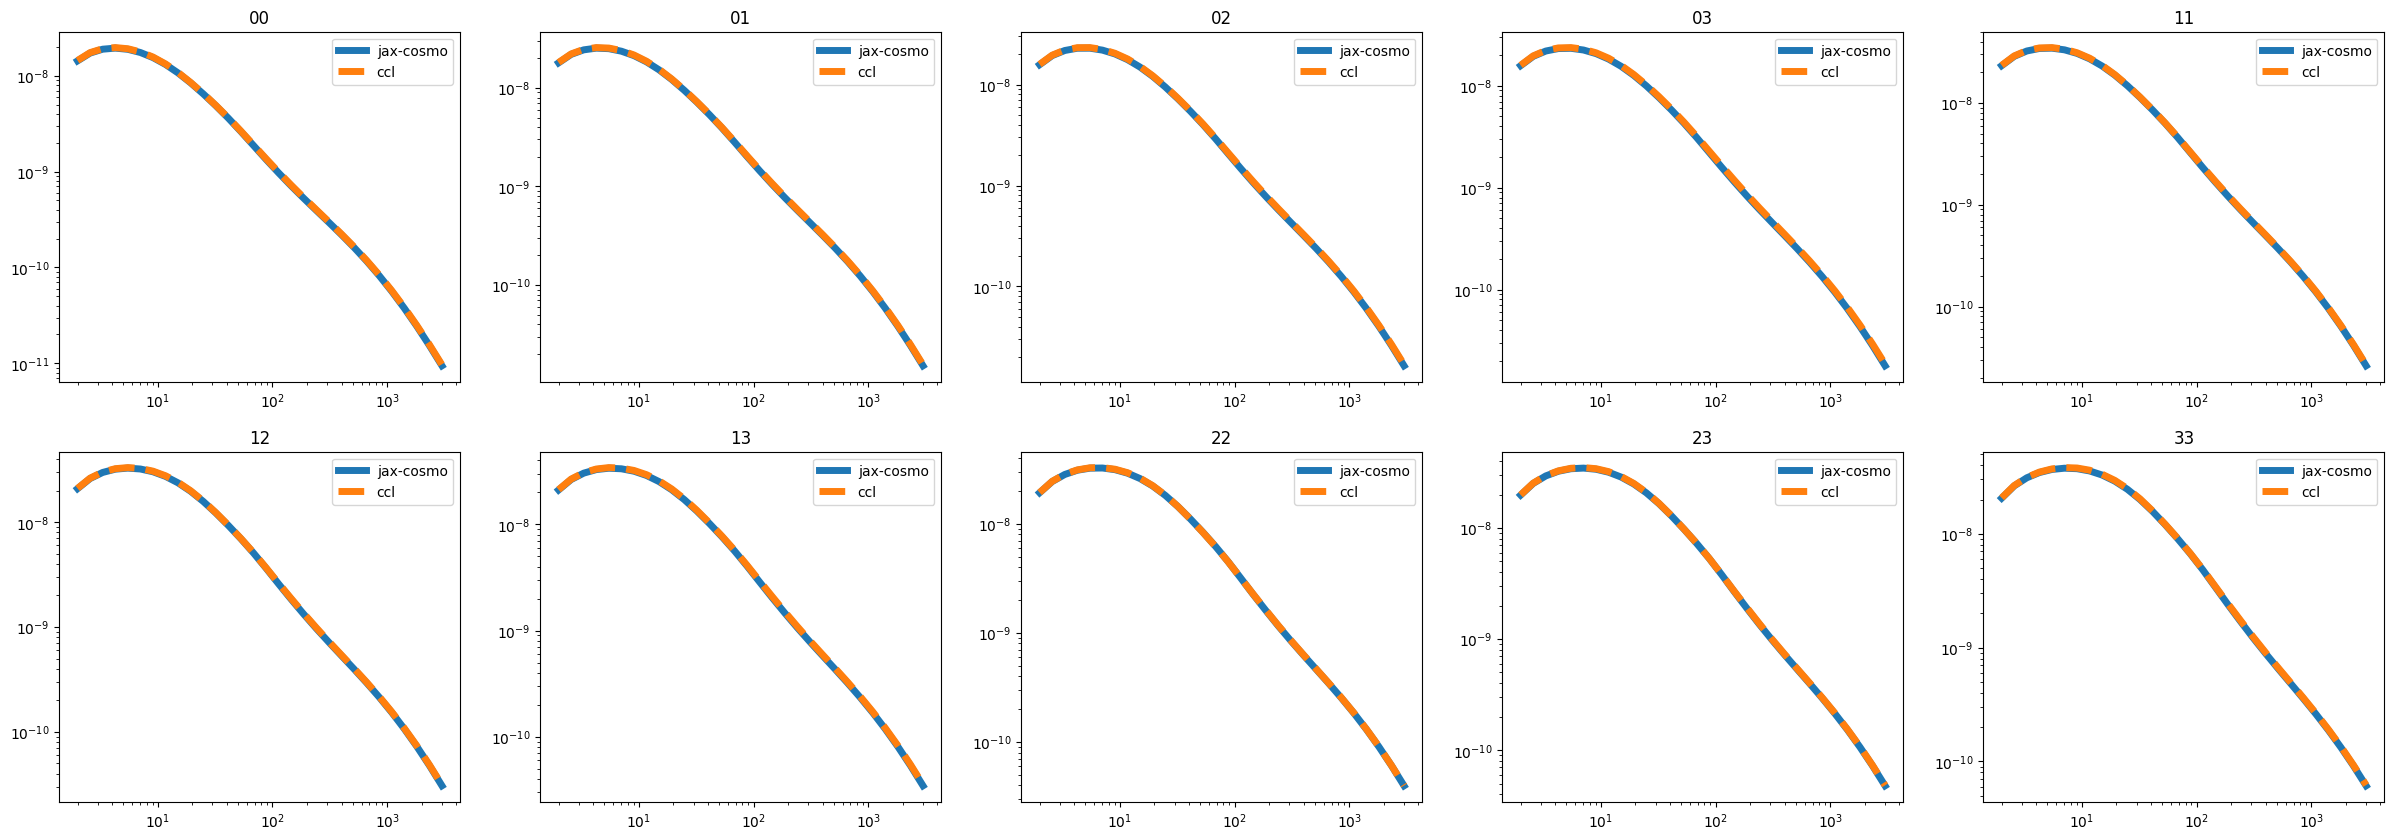

In [63]:
plt.figure(figsize = (30, 10))
counter = 0 
for i in range(4):
    for j in range(i, 4):
        plt.subplot(2, 5, counter+1)
        plt.title(f'{i}{j}')
        plt.loglog(ells_coarse_wl, ps_wl[counter], label = 'jax-cosmo', lw = 5)
        plt.loglog(ells_coarse_wl, cl_wl_ccl[counter], label = 'ccl', linestyle = '--', lw = 5)
        plt.legend()
        counter += 1
plt.show()

### Galaxy Clustering

In [64]:
cl_gc_ccl = []
for i in range(nbin_gc):
    z = jax_nz_gc[i].params[0]
    nz = jax_nz_gc[i].params[1]
    b = bias[i].item()
    # tracer = ccl.tracers.NumberCountsTracer(cosmo_ref, dndz=(z, nz), bias = (z, b*np.ones_like(z)), has_rsd=False)
    tracer = ccl.tracers.NumberCountsTracer(cosmo_cal, dndz=(z, nz), bias = (z, b*np.ones_like(z)), has_rsd=False)
    # cl = ccl.angular_cl(cosmo_ref, tracer, tracer, ells_coarse_gc)
    cl = ccl.angular_cl(cosmo_cal, tracer, tracer, ells_coarse_gc)
    cl_gc_ccl.append(cl)

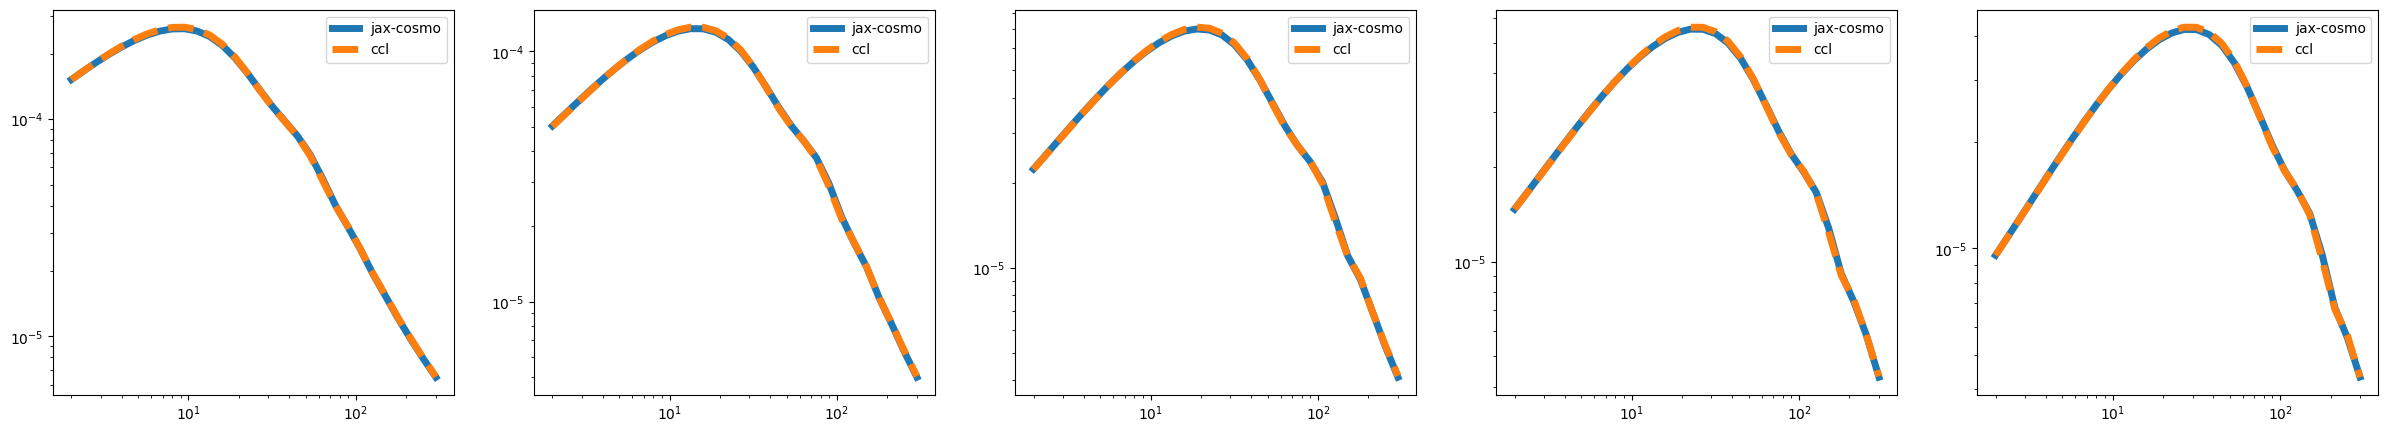

In [65]:
plt.figure(figsize = (30, 5))
for i in range(nbin_gc):
    plt.subplot(1, nbin_gc, i+1)
    plt.loglog(ells_coarse_gc, ps_gc[i], label = 'jax-cosmo', lw = 5)
    plt.loglog(ells_coarse_gc, cl_gc_ccl[i], label = 'ccl', linestyle = '--', lw = 5)
    plt.legend()
plt.show()

### Weak Lensing and Galaxy Clustering

In [66]:
cl_gc_wl_ccl = []
for i in range(nbin_gc):
    for j in range(nbin_wl):

        # gc 
        z_i = jax_nz_gc[i].params[0]
        nz_i = jax_nz_gc[i].params[1]
        b_i = bias[i].item()
        # t_i = ccl.tracers.NumberCountsTracer(cosmo_ref, dndz=(z_i, nz_i), bias = (z_i, b_i*np.ones_like(z_i)), has_rsd=False)
        t_i = ccl.tracers.NumberCountsTracer(cosmo_cal, dndz=(z_i, nz_i), bias = (z_i, b_i*np.ones_like(z_i)), has_rsd=False)
    
        # wl 
        z_j = jax_nz_wl[j].params[0]
        nz_j = jax_nz_wl[j].params[0]
        m_j = multiplicative[j].item()
        A_IA_j = intrinsic_alignment(z_j, a_ia_param, eta_param)
        # t_j = ccl.WeakLensingTracer(cosmo_ref, dndz=(z_j, nz_j), has_shear=False, ia_bias=(z_j, A_IA_j))
        t_j = ccl.WeakLensingTracer(cosmo_cal, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))

        # calculate the cls 
        # cl = ccl.angular_cl(cosmo_ref, t_i, t_j, ells_coarse_gc)  * (1.0 + m_j)
        cl = ccl.angular_cl(cosmo_cal, t_i, t_j, ells_coarse_gc)  * (1.0 + m_j)
        cl_gc_wl_ccl.append(cl)

In [67]:
cl_gc_wl_ccl[0]

array([1.39907211e-06, 1.64807293e-06, 1.89470539e-06, 2.13678952e-06,
       2.36932503e-06, 2.58451171e-06, 2.77166361e-06, 2.91728920e-06,
       3.00566151e-06, 3.02033497e-06, 2.94734578e-06, 2.77986099e-06,
       2.52503853e-06, 2.20838304e-06, 1.87236243e-06, 1.56454381e-06,
       1.31522354e-06, 1.11955124e-06, 9.47525685e-07, 7.74838401e-07,
       6.03736486e-07, 4.62847141e-07, 3.67749661e-07, 2.90936317e-07,
       2.24494113e-07, 1.77684209e-07, 1.40619518e-07, 1.12992227e-07,
       9.16654867e-08, 7.52921136e-08])

In [68]:
ps_gc_wl[0]

Array([5.51534019e-07, 6.47387875e-07, 7.41049887e-07, 8.31468633e-07,
       9.16575379e-07, 9.93345634e-07, 1.05780627e-06, 1.10506437e-06,
       1.12948132e-06, 1.12525734e-06, 1.08780374e-06, 1.01603451e-06,
       9.14776433e-07, 7.95549454e-07, 6.74355963e-07, 5.66503785e-07,
       4.79551605e-07, 4.08597738e-07, 3.42622030e-07, 2.77315916e-07,
       2.15942975e-07, 1.65506773e-07, 1.30331412e-07, 1.02431104e-07,
       7.95056159e-08, 6.28763037e-08, 4.99987364e-08, 4.03465709e-08,
       3.29239856e-08, 2.71710797e-08], dtype=float64)

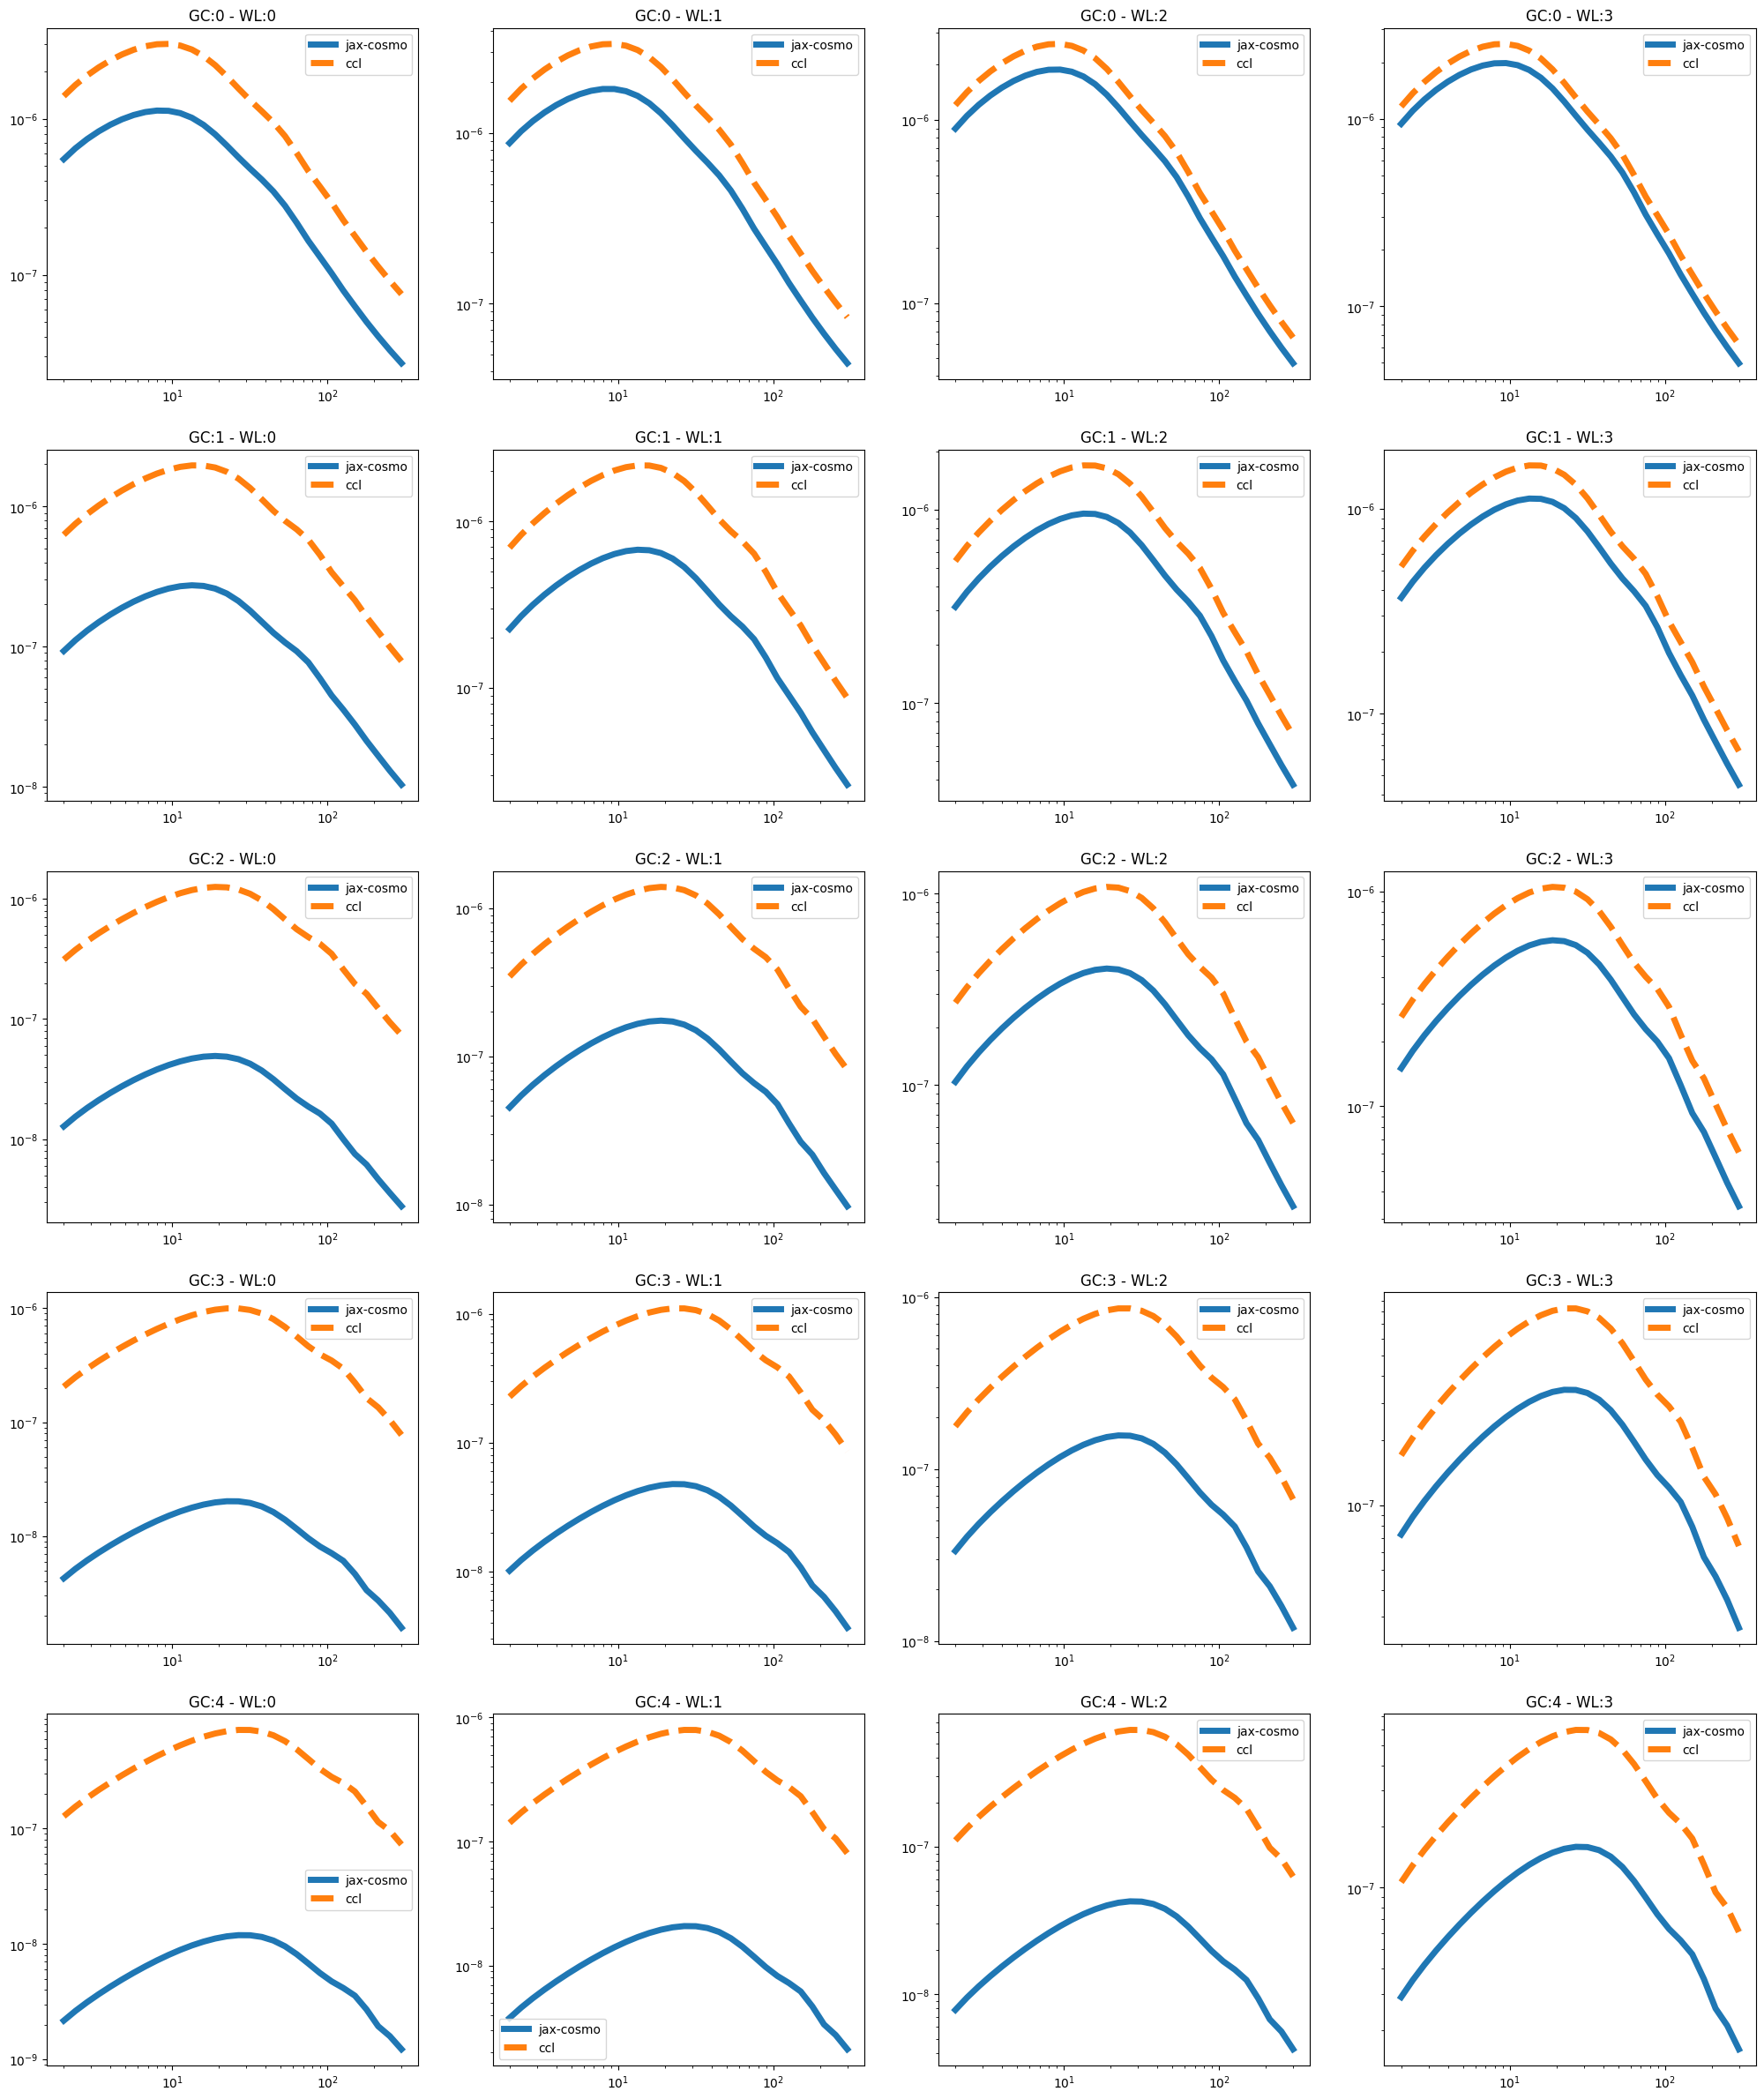

In [69]:
plt.figure(figsize = (25, 30))
counter = 0 
for i in range(nbin_gc):
    for j in range(nbin_wl):
        plt.subplot(nbin_gc, nbin_wl, counter+1)
        plt.title(f'GC:{i} - WL:{j}')
        plt.loglog(ells_coarse_gc, ps_gc_wl[counter], label = 'jax-cosmo', lw = 5)
        plt.loglog(ells_coarse_gc, cl_gc_wl_ccl[counter], label = 'ccl', linestyle = '--', lw = 5)
        plt.legend()
        counter += 1
# plt.savefig('plots/test-power-spectra.png')
plt.show()